In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
from quetzal.io import excel

# Modelling steps 1 and 2.
## Saves transport demand between zones
## Needs zones

In [3]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

### Emission and attraction with quetzal


Steps: Generation and distribution --> Transport demand in volumes<br>
Transport volumes can be generated by using the function<br>

step_distribution(impedance_matrix=None, **od_volume_from_zones_kwargs)<br>
    :param impedance_matrix: an OD unstaked friction dataframe<br>
        used to compute the distribution.<br>
    :param od_volume_from_zones_kwargs: if the friction matrix is not<br>
        provided, it will be automatically computed using a gravity<br>
        distribution which uses the following parameters:<br>
        param power: (int) the gravity exponent<br>
        param intrazonal: (bool) set the intrazonal distance to 0 if False,<br>
            compute a characteristic distance otherwise.<br>
            
Or create the volumes from input data<br>

### Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [6]:
vp2010 = pd.read_csv(input_path + 'PVMatrix_BVWP15_A2010.csv', sep=';', encoding='latin-1')
vp2030 = pd.read_csv(input_path + 'PVMatrix_BVWP15_P2030.csv', sep=';', encoding='latin-1')

In [7]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

In [8]:
assert len(vp2010[vp2010.isna().any(axis=1)]) == 0

In [9]:
def get_year(vp2010_i, vp2030_i, year=2017):
    return vp2010_i + (vp2030_i - vp2010_i) * ((year-2010) / 20)

In [10]:
# Calculate a OD table for the year given
vp = get_year(vp2010.set_index(['origin', 'destination']),
              vp2030.set_index(['origin', 'destination']),
              int(params['general']['year']))

In [11]:
print(vp.shape)
print(len(vp[vp.isna().any(axis=1)]))
vp.dropna(how='all', inplace=True)

(313990, 36)
594


In [12]:
vp = vp[list(vp.columns)].astype(int)
#vp.head()

### Create the volumes table

In [13]:
# Sum up trips by purpose
for suffix in ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz5', 'Fz6']:
    vp[suffix] = vp[[col for col in list(vp.columns) if col[-3:] == suffix]].sum(axis=1)

In [14]:
# Merge purpose 5 and 6 due to calibration data limitations
vp['Fz6'] = vp['Fz5'] + vp['Fz6']

In [15]:
# Replace LAU IDs with NUTS IDs in origin and destination
if not 'lau_id' in sm.zones.columns:
    sm.zones['lau_id'] = sm.zones['ARS'].apply(lambda l: l[0]).apply(str).str[:-4]
nuts_lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp.reset_index(level=['origin', 'destination'], inplace=True)

In [16]:
# Zones that appear in the VP (within Germany) but not in the model
sorted([i for i in set(list(vp['origin'])+list(vp['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3152,
 3156,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 13001,
 13002,
 13005,
 13006,
 13051,
 13052,
 13053,
 13054,
 13055,
 13056,
 13057,
 13058,
 13059,
 13060,
 13061,
 13062,
 14109,
 14119,
 16056]

In [17]:
# Most of the above numbers are airports in the VP, however
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075}
if len(sm.zones) > 401:
    update_dict[16056] = 16063

In [18]:
# What is the sum of all trips? For Validation
cols = [c for c in vp.columns if c not in ['origin', 'destination']]
orig_sum = vp[cols].sum().sum()
orig_sum

204502101389

In [19]:
# Update LAU codes
vp['origin'] = vp['origin'].replace(update_dict)
vp['destination'] = vp['destination'].replace(update_dict)

In [20]:
# Zones ending on 9 are international airports or ports
sorted([i for i in set(list(vp['origin'])+list(vp['destination'])) -
        set([int(k) for k in nuts_lau_dict.keys()]) if i<=16077])

[2109,
 3509,
 4109,
 5209,
 5219,
 5229,
 5239,
 5249,
 5269,
 6119,
 7009,
 8019,
 8029,
 8049,
 9019,
 9049,
 10109,
 11019,
 14109,
 14119]

In [21]:
# Replace LAU with NUTS
vp['origin'] = vp['origin'].astype(str).map(nuts_lau_dict)
vp['destination'] = vp['destination'].astype(str).map(nuts_lau_dict)

In [22]:
# Restrict to cells in the model
vp = vp[~vp.isna().any(axis=1)]

In [23]:
vp.shape

(169744, 44)

In [24]:
# What is the sum of all trips after ditching outer-German trips?
vp_sum = vp[cols].sum().sum()
vp_sum / orig_sum

0.9880382360504606

In [25]:
# Aggregate OD pairs
vp = vp.groupby(['origin', 'destination']).sum().reset_index()
vp[cols].sum().sum() / orig_sum

0.9880382360504606

In [26]:
sm.volumes = vp[['origin', 'destination', 'Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6']
               ].copy().set_index(['origin', 'destination'], drop=True)

### Add car ownership segments

Comment or uncomment the following cells to add or remove car ownership segments

In [27]:
# Car availabilities from MiD2017 data by VP2030 purpose
av = dict(zip(list(sm.volumes.columns),
              [0.970375, 0.965208, 0.968122, 0.965517, 0.95646]))

In [28]:
# Split purpose cells into car ownership classes
if len(params['general']['demand_segments'].split(';')) > 6:
    cols = list(sm.volumes.columns)
    for col in cols:
        for car in [0,1]:
            sm.volumes[col+'_'+str(car)] = sm.volumes[col] * abs(((1-car)*1 - av[col]))
    sm.volumes.drop(cols, axis=1, inplace=True)

In [29]:
sm.volumes.reset_index(inplace=True)

### Split into model zones

Use population shares of the NUTS3 sub-zone

In [40]:
sm.zones['pop_share'].sum()

401.0

In [52]:
vol = sm.zones[['FID', 'pop_share']].merge(sm.zones[['FID', 'pop_share']], how='cross'
                                          ).rename(columns={'FID_x':'origin', 'FID_y':'destination'})
island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
vol['o'] = vol['origin'].replace(island_dict).str[:5]
vol['d'] = vol['destination'].replace(island_dict).str[:5]
segments = [c for c in sm.volumes.columns if c not in ['origin', 'destination']]
for seg in segments:
    segment = sm.volumes.set_index(['origin', 'destination'])[seg].to_dict()
    vol[seg] = vol['pop_share_x'] * vol['pop_share_y'] * [
        segment[tuple(od)] 
        if tuple(od) in segment.keys() else np.nan
        for od in vol[['o', 'd']].values]

In [55]:
# Number of trips compared to before
vol[segments].sum() / sm.volumes[segments].sum()

Fz1_0    1.001707
Fz1_1    1.001707
Fz2_0    1.002788
Fz2_1    1.002788
Fz3_0    1.003099
Fz3_1    1.003099
Fz4_0    1.002269
Fz4_1    1.002269
Fz6_0    1.003633
Fz6_1    1.003633
dtype: float64

In [69]:
# Drop rows that did not exist in the VP volumes
# as there is no travel demand on these OD pairs
vol = vol.loc[~vol[segments].isna().all(axis=1)]
# Also drop OD pairs with 0 travel demand
vol = vol.loc[vol.sum(axis=1)>0]

In [71]:
assert vol.isna().any(axis=1).max() == 0
sm.volumes = vol[list(sm.volumes.columns)]

## Save model

In [77]:
sm.volumes.shape

(4910656, 12)

In [73]:
sm.volumes.columns

Index(['origin', 'destination', 'Fz1_0', 'Fz1_1', 'Fz2_0', 'Fz2_1', 'Fz3_0',
       'Fz3_1', 'Fz4_0', 'Fz4_1', 'Fz6_0', 'Fz6_1'],
      dtype='object')

In [78]:
# Empty rows?
assert len(sm.volumes.loc[sm.volumes.sum(axis=1)==0])==0

In [79]:
# Saving volumes
sm.to_json(model_path + 'de_volumes',
           only_attributes=['volumes'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:32<00:00,  1.04it/s]


## Create validation table

Generate a normalised matrix for the year 2017 in order to validate model results against each other. It is needed for the calibration step.

In [30]:
# Merge purpose 5 and 6
for prefix in ['Bahn', 'MIV', 'Luft', 'OESPV', 'Rad', 'Fuß']:
    vp[prefix + '_Fz6'] = vp[prefix + '_Fz5'] + vp[prefix + '_Fz6']
vp = vp[[col for col in list(vp.columns) if col[-1]!='5']]

In [31]:
# Merge bicycle and foot
for p in [1,2,3,4,6]:
    vp['non_motor_Fz' + str(p)] = vp['Rad_Fz' + str(p)] + vp['Fuß_Fz' + str(p)]
vp = vp[[col for col in list(vp.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [32]:
# Prepare columns
vp.set_index(['origin', 'destination'], drop=True, inplace=True)
vp = vp[[col for col in vp.columns if col[:2]!='Fz']]
vp.columns

Index(['Bahn_Fz1', 'Bahn_Fz2', 'Bahn_Fz3', 'Bahn_Fz4', 'Bahn_Fz6', 'MIV_Fz1',
       'MIV_Fz2', 'MIV_Fz3', 'MIV_Fz4', 'MIV_Fz6', 'Luft_Fz1', 'Luft_Fz2',
       'Luft_Fz3', 'Luft_Fz4', 'Luft_Fz6', 'OESPV_Fz1', 'OESPV_Fz2',
       'OESPV_Fz3', 'OESPV_Fz4', 'OESPV_Fz6', 'non_motor_Fz1', 'non_motor_Fz2',
       'non_motor_Fz3', 'non_motor_Fz4', 'non_motor_Fz6'],
      dtype='object')

In [33]:
# Normalise
vp_norm = (vp-vp.min())/(vp.max()-vp.min()).max()

In [34]:
vp_norm.sample(5)

,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,MIV_Fz6,...,OESPV_Fz1,OESPV_Fz2,OESPV_Fz3,OESPV_Fz4,OESPV_Fz6,non_motor_Fz1,non_motor_Fz2,non_motor_Fz3,non_motor_Fz4,non_motor_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,
DE219,DEB37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.971456e-09,0.000000,0.000000e+00,0.000000,2.010910e-07,7.844212e-07,...,0.0,0.0,0.0,0.000000e+00,1.495718e-08,0.0,0.0,0.0,0.0,0.0
DE40E,DE402,3.273961e-07,9.306692e-08,1.096860e-07,1.911196e-07,3.224104e-06,0.000030,6.149064e-07,0.000006,1.349304e-05,4.450095e-05,...,0.0,0.0,0.0,1.661909e-09,8.824738e-07,0.0,0.0,0.0,0.0,0.0
DE21B,DEG0H,0.000000e+00,0.000000e+00,0.000000e+00,3.323819e-09,6.149064e-08,0.000000,0.000000e+00,0.000000,2.443007e-07,2.250225e-06,...,0.0,0.0,0.0,0.000000e+00,9.472883e-08,0.0,0.0,0.0,0.0,0.0
DEG0E,DEA18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.971456e-09,0.000000,0.000000e+00,0.000000,1.346147e-07,4.653346e-07,...,0.0,0.0,0.0,0.000000e+00,1.329527e-08,0.0,0.0,0.0,0.0,0.0
DE714,DEB3G,6.813828e-08,3.490010e-08,7.977165e-08,3.157628e-08,4.836156e-07,0.000018,8.515623e-06,0.000035,2.604212e-05,3.908811e-05,...,0.0,0.0,0.0,0.000000e+00,8.658548e-07,0.0,0.0,0.0,0.0,0.0


In [35]:
# Save normalised table
vp_norm.to_csv(input_path + 'vp'+str(params['general']['year'])+'_validation_normalised.csv')

In [36]:
vp_norm.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[0], col.split('_')[-1]) for col in vp_norm.columns],
    names=['mode', 'segment'])

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

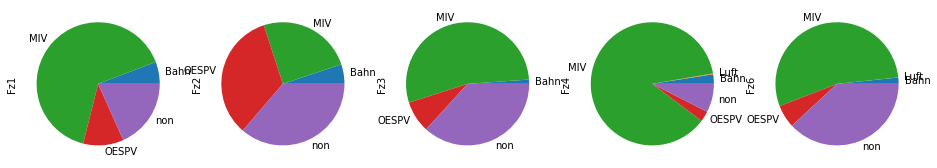

In [37]:
# Total traffic volumes by trip purpose
if manual:
    vp_norm.T.sum(axis=1).unstack('segment').plot.pie(
        subplots=True, figsize=(16, 4), legend=False)

In [38]:
# Restrict to inter-cell traffic and cells of the model
vp_norm.reset_index(level=['origin', 'destination'], inplace=True)
vp_norm = vp_norm.loc[(vp_norm['origin']!=vp_norm['destination']) &
                      (vp_norm['origin'].notna()) &
                      (vp_norm['destination'].notna())]
vp_norm.set_index(['origin', 'destination'], drop=True, inplace=True)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

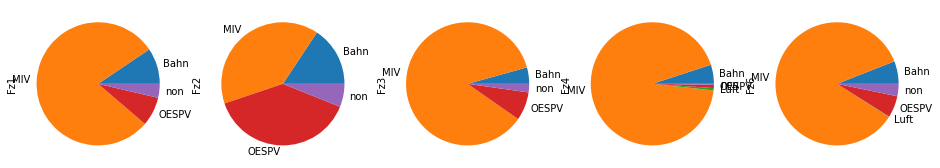

In [39]:
# Inter-zonal travel volumes
if manual:
    vp_norm.T.sum(axis=1).unstack('segment').plot.pie(
        subplots=True, figsize=(16, 4), legend=False)

In [40]:
# Clear the RAM if notebook stays open
vp2010 = None
vp2030 = None